In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

### Generating our dataset from webscraping Metacritic.com

In [41]:
# Set headers to mimic a browser request
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/96.0.4664.93 Safari/537.36',
}

# URLs of the pages to scrape
urls = [
    'https://www.metacritic.com/browse/games/release-date/available/xbox-series-x/metascore',
    'https://www.metacritic.com/browse/games/release-date/available/xbox-series-x/metascore?page=1',
    'https://www.metacritic.com/browse/games/release-date/available/xbox-series-x/metascore?page=2',
    'https://www.metacritic.com/browse/games/release-date/available/xbox-series-x/metascore?page=3',
    'https://www.metacritic.com/browse/games/release-date/available/xbox-series-x/metascore?page=4'
]

data_list = []

for url in urls:
    
    response = requests.get(url, headers=headers)

    
    soup = BeautifulSoup(response.content, 'html.parser')

    
    games = soup.find_all('td', class_='clamp-summary-wrap')

    for game in games:
        title = game.find('h3').text.strip()
        critic_score = game.find('div', class_='metascore_w').text.strip()
        user_score_element = game.find('div', class_='metascore_w user large game mixed')
        user_score = user_score_element.text.strip() if user_score_element else 'N/A'
        summary = game.find('div', class_='summary').text.strip()
        release_date_element = game.find('div', class_='clamp-details').find_all('span')[-1]
        release_date = release_date_element.text.strip() if release_date_element else 'N/A'
    

        # Create a dictionary to store the data
        data = {
            'Title': title,
            'Critic Score': critic_score,
            'User Score': user_score,
            'Summary': summary,
            'Release Date': release_date
        }
        data_list.append(data)


df = pd.DataFrame(data_list)

The above process demonstrates web scraping using Python and the BeautifulSoup library to extract data from a series of URLs related to Xbox Series X games on the website Metacritic. The goal is to create a dataset containing information about game titles, release dates, and Metascores and later one using the meaningful information to retrieve relevant information from the data.

In [42]:
df

Title Critic Score User Score  \
0                                     Elden Ring           96        N/A   
1                              Vampire Survivors           95        N/A   
2                                Persona 5 Royal           94        N/A   
3    The Witcher 3: Wild Hunt - Complete Edition           94        N/A   
4                                          Hades           93        N/A   
..                                           ...          ...        ...   
452                                    Blackwind           48        N/A   
453            Police Simulator: Patrol Officers           48        6.5   
454                            Balan Wonderworld           47        7.1   
455                       Krut: The Mythic Wings           43        N/A   
456                                   CrossfireX           38        N/A   

                                               Summary       Release Date  
0    A New World Created By Hidetaka Miyazaki And G...  February 25, 2022  
1    Mow thousands of night creatures and survive u...  November 10, 2022  
2    Prepare for an all-new RPG experience in Perso...   October 21, 2022  
3    You are Geralt of Rivia, mercenary monster sla...   January 26, 2023  
4    Defy the god of the dead as you hack and slash...    August 13, 2021  
..                                                 ...                ...  
452  Blackwind is a hack n slash shooter platformer...   January 20, 2022  
453  Welcome to Brighton! \n\nJoin the police force...  November 10, 2022  
454  BALAN WONDERWORLD is an action platformer game...     March 26, 2021  
455  Krut: The Mythic Wings is a fast-paced hack an...      July 12, 2022  
456  CrossfireX delivers an intense first-person sh...  February 10, 2022  

[457 rows x 5 columns]

## Clustering our data

TfidfVectorizer was employed in the project to convert game descriptions and reviews into numerical feature vectors for unsupervised learning-based clustering. By combining Term Frequency (TF) and Inverse Document Frequency (IDF), TfidfVectorizer calculated the TF-IDF score for each term in every document, thereby highlighting the importance of words in relation to the entire corpus. This allowed the algorithm to identify significant gaming-related terms, reduce dimensionality, and create meaningful clusters based on distinguishing characteristics, resulting in an efficient and effective approach for organizing Xbox Series X games according to their content and features.


#### K = 5

In [49]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Combine the summary and release date columns into a single text column
df['Text'] = df['Summary'] + ' ' + df['Release Date']


vectorizer = TfidfVectorizer()

# Fit and transform the data
X = vectorizer.fit_transform(df['Text'])

# Initialize the K-means clustering model
k = 5  # Set the number of clusters
kmeans = KMeans(n_clusters=k, random_state=42)

# Perform clustering
kmeans.fit(X)

# Get the cluster labels
cluster_labels = kmeans.labels_

# Add the cluster labels to the dataset
df['Cluster'] = cluster_labels

# Print the cluster assignments
print(df[['Title', 'Cluster']])

/Users/Felipe/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


                                           Title  Cluster
0                                     Elden Ring        2
1                              Vampire Survivors        0
2                                Persona 5 Royal        0
3    The Witcher 3: Wild Hunt - Complete Edition        2
4                                          Hades        0
..                                           ...      ...
452                                    Blackwind        1
453            Police Simulator: Patrol Officers        2
454                            Balan Wonderworld        2
455                       Krut: The Mythic Wings        1
456                                   CrossfireX        2

[457 rows x 2 columns]


### Metrics

In [50]:
vectorizer = TfidfVectorizer()

# Fit and transform the data
X = vectorizer.fit_transform(df['Text'])


def evaluate_clustering(k, X, cluster_labels):
    kmeans = KMeans(n_clusters=k, random_state=50)
    kmeans.fit(X)
    
    # Calculate WCSS
    wcss = kmeans.inertia_
    
    # Calculate silhouette score
    silhouette = silhouette_score(X, kmeans.labels_)
    
    return wcss, silhouette

# Try different values of k
k_values = range(2, 11)
wcss_scores = []
silhouette_scores = []


for k in k_values:
    wcss, silhouette = evaluate_clustering(k, X, cluster_labels)
    wcss_scores.append(wcss)
    silhouette_scores.append(silhouette)

# Plot the WCSS scores
plt.figure(figsize=(10, 6))
plt.plot(k_values, wcss_scores, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.title('Within-Cluster Sum of Squares (WCSS) for Different Values of k')
plt.show()

# Plot the silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(k_values, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Different Values of k')
plt.show()

/Users/Felipe/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/Felipe/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/Felipe/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/Felipe/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/Felipe/an

The value of the Silhouette score varies from -1 to 1. If the score is 1, the cluster is dense and well-separated than other clusters. A silhouette scores near 0 indicate overlapping clusters, and negative values generally indicate that a sample has been assigned to the wrong cluster, as a different cluster is more similar. In our case,  the clustering model is having difficulty clearly separating the data into distinct groups, and that the data points may be very similar to each other regardless of the cluster they're in.

The WCSS (Within-Cluster-Sum-of-Squares), or inertia, is the sum of the squared distances from each data point to the centroid of its assigned cluster. Lower values of WCSS indicate that data points in each cluster are closer to their centroid, which is generally a sign of better clustering because points in the same cluster are more similar to each other. However, increasing the number of clusters will always decrease the WCSS, up to the point where if each data point is its own cluster, then the WCSS will be zero. So, the goal is not to minimize the WCSS to zero, but to find the point where adding additional clusters doesn't offer a substantial reduction in the WCSS. This would be the optimal number of clusters that balances both the compactness of the clusters (WCSS) and the number of clusters. In our case, WCSS values start around 420 for 2 clusters and decrease only slightly to around 410 for 9 clusters, it suggests that adding more clusters beyond 2 doesn't significantly improve the compactness of the clusters. In other words, even though you are adding more clusters, the data points are not getting much closer to their respective centroids.

/Users/Felipe/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/Felipe/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/Felipe/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/Felipe/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/Felipe/an

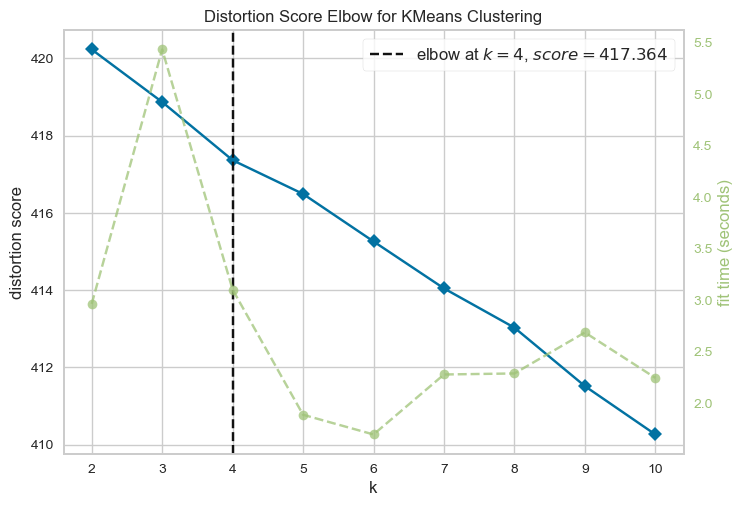

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [51]:
from yellowbrick.cluster import KElbowVisualizer

# Convert your matrix to a numpy array
X_array = np.asarray(X.todense())

# Instantiate the clustering model and visualizer
km = KMeans(random_state=42)
visualizer = KElbowVisualizer(km, k=(2,11))

visualizer.fit(X_array)
visualizer.show()  

### K = 4

In [52]:
vectorizer = TfidfVectorizer()

# Fit and transform the data
X = vectorizer.fit_transform(df['Text'])

# Initialize the K-means clustering model
k = 4  # Set the number of clusters
kmeans = KMeans(n_clusters=k, random_state=42)

# Perform clustering
kmeans.fit(X)

# Get the cluster labels
cluster_labels = kmeans.labels_

# Add the cluster labels to the dataset
df['Cluster'] = cluster_labels

# Print the cluster assignments
print(df[['Title', 'Cluster']])

/Users/Felipe/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


                                           Title  Cluster
0                                     Elden Ring        1
1                              Vampire Survivors        3
2                                Persona 5 Royal        3
3    The Witcher 3: Wild Hunt - Complete Edition        3
4                                          Hades        3
..                                           ...      ...
452                                    Blackwind        0
453            Police Simulator: Patrol Officers        3
454                            Balan Wonderworld        3
455                       Krut: The Mythic Wings        2
456                                   CrossfireX        2

[457 rows x 2 columns]


In [53]:
# Print the titles and their corresponding clusters
for cluster in range(k):
    cluster_data = df[df['Cluster'] == cluster]['Title']
    print("Cluster", cluster)
    print(cluster_data)
    print()

Cluster 0
5      The Stanley Parable: Ultra Deluxe
10                       Resident Evil 4
14                            Dead Space
34                         Psychonauts 2
44                    The Forgotten City
                     ...                
439                     Hello Neighbor 2
440                                Yuoni
445           The Dead Tree of Ranchiuna
449                             Trenches
452                            Blackwind
Name: Title, Length: 62, dtype: object

Cluster 1
0                                 Elden Ring
7                                  Diablo IV
22                               Immortality
24                          Cult of the Lamb
28      ENDER LILIES: Quietus of the Knights
                       ...                  
414                         Homestead Arcana
431    Werewolf: The Apocalypse - Earthblood
441             Serious Sam 4: Planet Badass
442                            Bright Memory
446                Dragon Ball: The Bre

In [54]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.toarray())

# Create the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='viridis')
plt.title('Clustering of Text Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.show()


### K = 2 Our ideal number of clusters

In [55]:
vectorizer = TfidfVectorizer()

# Fit and transform the data
X = vectorizer.fit_transform(df['Text'])

# Initialize the K-means clustering model
k = 2  # Set the number of clusters
kmeans = KMeans(n_clusters=k, random_state=42)

# Perform clustering
kmeans.fit(X)

# Get the cluster labels
cluster_labels = kmeans.labels_

# Add the cluster labels to the dataset
df['Cluster'] = cluster_labels

# Print the cluster assignments
print(df[['Title', 'Cluster']])

                                           Title  Cluster
0                                     Elden Ring        0
1                              Vampire Survivors        1
2                                Persona 5 Royal        1
3    The Witcher 3: Wild Hunt - Complete Edition        1
4                                          Hades        1
..                                           ...      ...
452                                    Blackwind        1
453            Police Simulator: Patrol Officers        1
454                            Balan Wonderworld        1
455                       Krut: The Mythic Wings        0
456                                   CrossfireX        0

[457 rows x 2 columns]


/Users/Felipe/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [56]:
# Print the reviews and their corresponding clusters
for cluster in range(k):
    cluster_data = df[df['Cluster'] == cluster]['Title']
    print("Cluster", cluster)
    print(cluster_data)
    print()

Cluster 0
0                        Elden Ring
6                   Forza Horizon 5
12       Microsoft Flight Simulator
13                 Street Fighter 6
19     Tony Hawk's Pro Skater 1 + 2
                   ...             
441    Serious Sam 4: Planet Badass
443             Tennis World Tour 2
444                    Saga of Sins
455          Krut: The Mythic Wings
456                      CrossfireX
Name: Title, Length: 177, dtype: object

Cluster 1
1                                Vampire Survivors
2                                  Persona 5 Royal
3      The Witcher 3: Wild Hunt - Complete Edition
4                                            Hades
5                The Stanley Parable: Ultra Deluxe
                          ...                     
450                          Music Racer: Ultimate
451                                The Last Oricru
452                                      Blackwind
453              Police Simulator: Patrol Officers
454                              

In [57]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.toarray())

# Create the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='viridis')
plt.title('Clustering of Text Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.show()

PC1 and PC2 obtained through PCA represent new variables that capture the most important information in the data while reducing its dimensionality. These components are orthogonal and allow for visualizing and analyzing the data in a lower-dimensional space, aiding in data exploration and pattern recognition.

In the context of this data, the X and Y values represent the coordinates of each data point in the reduced two-dimensional space obtained through PCA. The X-axis corresponds to the values of the first principal component, and the Y-axis corresponds to the values of the second principal component. These components are linear combinations of the original features and are chosen in a way that maximizes the variance in the data, as seen in class.

The clusters are defined by the grouping of data points that are close to each other in this reduced space. Points (in this case videogames) that belong to the same cluster are more similar to each other in terms of their feature values compared to points in the other cluster.

In [58]:
df

Title Critic Score User Score  \
0                                     Elden Ring           96        N/A   
1                              Vampire Survivors           95        N/A   
2                                Persona 5 Royal           94        N/A   
3    The Witcher 3: Wild Hunt - Complete Edition           94        N/A   
4                                          Hades           93        N/A   
..                                           ...          ...        ...   
452                                    Blackwind           48        N/A   
453            Police Simulator: Patrol Officers           48        6.5   
454                            Balan Wonderworld           47        7.1   
455                       Krut: The Mythic Wings           43        N/A   
456                                   CrossfireX           38        N/A   

                                               Summary       Release Date  \
0    A New World Created By Hidetaka Miyazaki And G...  February 25, 2022   
1    Mow thousands of night creatures and survive u...  November 10, 2022   
2    Prepare for an all-new RPG experience in Perso...   October 21, 2022   
3    You are Geralt of Rivia, mercenary monster sla...   January 26, 2023   
4    Defy the god of the dead as you hack and slash...    August 13, 2021   
..                                                 ...                ...   
452  Blackwind is a hack n slash shooter platformer...   January 20, 2022   
453  Welcome to Brighton! \n\nJoin the police force...  November 10, 2022   
454  BALAN WONDERWORLD is an action platformer game...     March 26, 2021   
455  Krut: The Mythic Wings is a fast-paced hack an...      July 12, 2022   
456  CrossfireX delivers an intense first-person sh...  February 10, 2022   

                                                  Text  Cluster  
0    A New World Created By Hidetaka Miyazaki And G...        0  
1    Mow thousands of night creatures and survive u...        1  
2    Prepare for an all-new RPG experience in Perso...        1  
3    You are Geralt of Rivia, mercenary monster sla...        1  
4    Defy the god of the dead as you hack and slash...        1  
..                                                 ...      ...  
452  Blackwind is a hack n slash shooter platformer...        1  
453  Welcome to Brighton! \n\nJoin the police force...        1  
454  BALAN WONDERWORLD is an action platformer game...        1  
455  Krut: The Mythic Wings is a fast-paced hack an...        0  
456  CrossfireX delivers an intense first-person sh...        0  

[457 rows x 7 columns]

In [59]:
df['Critic Score'] = pd.to_numeric(df['Critic Score'])
cluster_scores = df.groupby('Cluster')['Critic Score'].mean()

# Get the cluster with the higher average critic score
better_cluster = np.argmax(cluster_scores)

print("Cluster", better_cluster, "has better critic scores with an average score of", cluster_scores[better_cluster])

Cluster 1 has better critic scores with an average score of 75.00714285714285


In [60]:
cluster_scores

Cluster
0    74.666667
1    75.007143
Name: Critic Score, dtype: float64

In [61]:
# Convert 'Release Date' column to datetime format
df['Release Date'] = pd.to_datetime(df['Release Date'])

# Calculate mean release date for each cluster
cluster_mean_dates = df.groupby('Cluster')['Release Date'].mean()

for cluster, mean_date in cluster_mean_dates.items():
    print("Cluster", cluster)
    print("Mean Release Date:", mean_date)
    print()


Cluster 0
Mean Release Date: 2022-03-30 15:43:43.728813568

Cluster 1
Mean Release Date: 2022-05-01 13:48:00



We wanted to see if the data in the clusters had similar critics score or if the release date were similar, but both clusters have similar means, this suggests that the clusters could be definied by other similarities such as the genre or category of the game.

### Randomly Assigned Clusters

In [62]:
np.random.seed(42)  # Set a seed for reproducibility
df['Cluster'] = np.random.randint(0, 2, size=len(df))

# Calculate the mean critic score for each cluster
cluster_scores = df.groupby('Cluster')['Critic Score'].mean()

# Get the cluster with the higher average critic score
better_cluster = np.argmax(cluster_scores)

print("Cluster", better_cluster, "has better critic scores with an average score of", cluster_scores[better_cluster])

Cluster 0 has better critic scores with an average score of 75.38009049773756


In [63]:
# Print the reviews and their corresponding clusters
for cluster in range(k):
    cluster_data = df[df['Cluster'] == cluster]['Title']
    print("Cluster", cluster)
    print(cluster_data)
    print()

Cluster 0
0                                       Elden Ring
2                                  Persona 5 Royal
3      The Witcher 3: Wild Hunt - Complete Edition
4                                            Hades
6                                  Forza Horizon 5
                          ...                     
445                     The Dead Tree of Ranchiuna
446                      Dragon Ball: The Breakers
448                                 Blood Bowl III
454                              Balan Wonderworld
455                         Krut: The Mythic Wings
Name: Title, Length: 221, dtype: object

Cluster 1
1                      Vampire Survivors
5      The Stanley Parable: Ultra Deluxe
9           Disco Elysium: The Final Cut
14                            Dead Space
16                          It Takes Two
                     ...                
450                Music Racer: Ultimate
451                      The Last Oricru
452                            Blackwind
453    Po

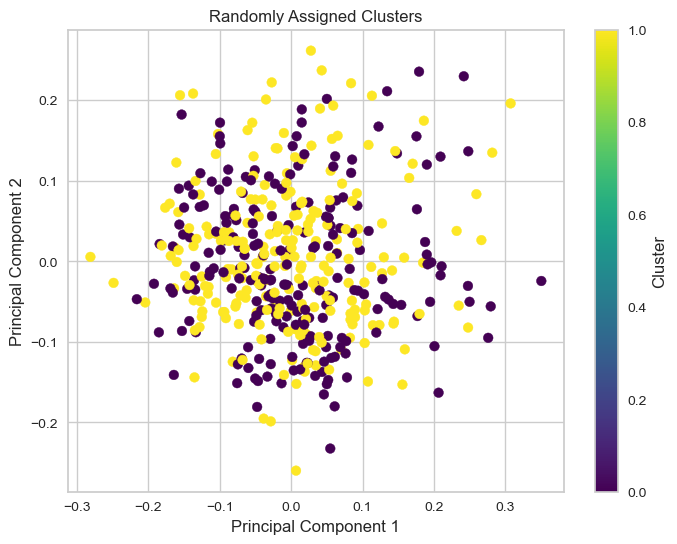

In [64]:
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['Cluster'], cmap='viridis')
plt.title('Randomly Assigned Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.show()
